In [9]:
import torch
from torch import nn
from torchvision import transforms # Preprocess jpg images
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

In [1]:
flickr8k_path = '/scratch/lt2318-h21-resources/03-image-captioning/data/flickr8k/'
flickr8K_caps = flickr8k_path + 'captions.txt'
flickr8K_imgs = flickr8k_path + 'Images/'

In [2]:
with open(flickr8K_caps, "r") as f:
     lines = [l for l in f]
len(lines)

40456

In [9]:
fns = [l.split(",")[0] for l in lines[1:]]
fns[:5]

['1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg',
 '1000268201_693b08cb0e.jpg']

In [10]:
len(set(fns))

8091

In [11]:
8091*5

40455

In [2]:
tensor_to_PIL = transforms.ToPILImage()

In [139]:
def file_to_tensor(img_path):
    # (PIL.Image obj) => pt tensor 3x224x224
    # load jpg directly as tensor of CxHxW to avoid needing converting from numpy and permuting

    preprocess_fn = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    # PIL Img obj
    with Image.open(img_path) as img:
        img_tensor = preprocess_fn(img)
        return img_tensor



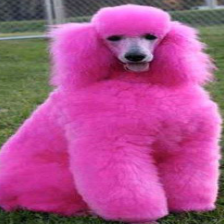

In [140]:
img_tensor = file_to_tensor('pinkdog1.jpg')
pil = tensor_to_PIL(img_tensor)
pil

In [126]:
augment_fn = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
                transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2),
                                        shear=None,  interpolation=transforms.InterpolationMode.NEAREST, 
                                        fill=(255, 255, 255)),
                transforms.ToTensor(),
                ])



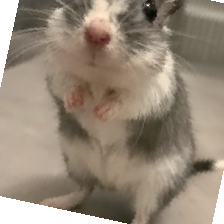

In [127]:
aug_tensor = augment_fn(img_tensor)
tensor_to_PIL(aug_tensor)

In [255]:
list(resnet.children())[8]

AdaptiveAvgPool2d(output_size=(1, 1))

In [355]:
import torch.nn as nn
class SubNet(nn.Module):
    '''
    encoder module
    - use pre-trained encoder: ResNet101 trained on ImageNet classification task
    '''

    def __init__(self, num_classes, encoded_image_size=14, hidden_size=2048, fine_tune=False):
        super(SubNet, self).__init__()
        self.enc_image_size = encoded_image_size # resnet out: 14 x 14
        
        # Exclude ResNet's last 2 layers (avgpool & fc1000) for image representations
        resnet = torchvision.models.resnet101(pretrained=True) # Pretrained ResNet101 model
        resnet_layers = list(resnet.children())
        resnet_abstrations = resnet_layers[:-1]
        
        self.resnet = nn.Sequential(*resnet_abstrations) # Output = image abstract reps
        
        # fc 
        self.fc_layers = nn.Sequential(
                                       nn.Linear(2048, num_classes),
                                       nn.Softmax(1),
                                      )
        
        # Enable finetuning
        self.fine_tune(fine_tune=fine_tune)


    def forward(self, images):
        '''
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        '''
        out = self.resnet(images)  # (batch_size, 2048, image_size/32, image_size/32)

        out = out.view(out.shape[0], -1) # Keep batch and flatten other dims
        out = self.fc_layers(out)
        return out

    def fine_tune(self, fine_tune=True):

        for p in self.resnet.parameters():
            p.requires_grad = False
        # If fine-tuning, only fine-tune convolutional blocks 2 through 4
        for c in list(self.resnet.children())[5:]: # 3 bottleneck blocks
            for p in c.parameters():
                p.requires_grad = fine_tune

In [356]:
def train_SubNet(epochs, train_data, val_data, batch_size, device, target_idx, num_classes, lr=0.001):
    
    #Batch iterator
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    
    m = SubNet(num_classes, fine_tune=True)
    m.to(device)
    loss_fn = nn.CrossEntropyLoss() # ignore y padding
    optimizer = optim.Adam(m.parameters(), lr=lr)
    
    #Epoch loop
    
    for e in range(epochs):
#         start_time = datetime.now()
        # Train
        m.train()
        train_loss = 0
        for i, data in enumerate(train_loader):
            x, y = data[0].to(device), data[target_idx].to(device)
            
            out = m(x)
            
            loss = loss_fn(out, y) 
            train_loss += loss.item()
            
            # Compute gradient and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {e+1} avg train loss {train_loss/(i+1)}", end='\r')
        print(end="\t")
#         torch.save(m, model_fn)
        
        # Eval
        m.eval()
        with torch.no_grad():
            val_loss = 0
            for i, data in enumerate(train_loader):
                x, y = data[0].to(device), data[target_idx].to(device)

                out = m(x)

                loss = loss_fn(out, y) 
                val_loss += loss.item()
                
                print(f"Epoch {e+1} avg val loss {val_loss/(i+1)}", end='\r')
            print()

    return m

In [357]:
adj_net = train_SubNet(epochs=10, 
                       train_data=train_data, val_data=val_data, 
                       batch_size=10, device='cuda:0', 
                       target_idx=2, num_classes=19,)

Epoch 1 avg val loss 2.819449972389336456
Epoch 2 avg val loss 2.818821192684030376
Epoch 3 avg val loss 2.809708551356667488
Epoch 4 avg val loss 2.815643592884666613Epoch 4 avg val loss 2.9308314323425293
Epoch 5 avg val loss 2.775810185231660667Epoch 5 avg val loss 2.6581003665924072
Epoch 6 avg val loss 2.770032176397797444Epoch 6 avg val loss 2.9292616844177246
Epoch 7 avg val loss 2.773491842406136897
Epoch 8 avg val loss 2.763045155016103365
Epoch 9 avg val loss 2.769557967221826593Epoch 9 avg val loss 2.8309099674224854
Epoch 10 avg val loss 2.750629019020195713Epoch 10 avg val loss 2.8301072120666504


In [326]:
noun_net = train_SubNet(epochs=10, 
                       train_data=train_data, val_data=val_data, 
                       batch_size=10, device='cuda:0', 
                       target_idx=3, num_classes=16,)

Epoch 1 avg val loss 2.540270895886242763Epoch 1 avg val loss 2.1748263835906982
Epoch 2 avg val loss 2.511951296849358348Epoch 2 avg val loss 2.299464464187622
Epoch 3 avg val loss 2.566043402019362427Epoch 3 avg val loss 2.3440146446228027
Epoch 4 avg val loss 2.572706419722478324Epoch 4 avg val loss 2.6704936027526855
Epoch 5 avg val loss 2.576112430794794743
Epoch 6 avg val loss 2.528272915603523334
Epoch 7 avg val loss 2.513878119619269377
Epoch 8 avg val loss 2.513521482173661333
Epoch 9 avg val loss 2.552891113704308426Epoch 9 avg val loss 2.306199550628662
Epoch 10 avg val loss 2.510596774574509693


In [331]:
class ANPNet(nn.Module):
 
 
    def __init__(self, num_ANPs=304, num_adjs=19, num_nouns=16 ,hidden_size=1024):
        super(ANPNet, self).__init__()
        
        # Sub modules
#         self.adj_net = SubNet(num_adjs, hidden_size=hidden_size)
#         self.noun_net = SubNet(num_adjs, hidden_size=hidden_size)
        self.adj_net = adj_net
        self.adj_net.fine_tune(fine_tune=False)
        self.noun_net = noun_net
        self.noun_net.fine_tune(fine_tune=False)
        
        # fuse fc 
        self.fc_layers = nn.Sequential(nn.Linear(hidden_size, 1024),
                                       nn.ReLU(),
                                       nn.Linear(1024, num_ANPs),
                                       nn.Softmax(1)
                                      )
        
        
        
        self.lin = nn.Linear(num_adjs+num_nouns, hidden_size)


    def forward(self, images):
        '''
        Forward propagation.
        :param images: images, a tensor of dimensions (batch_size, 3, image_size, image_size)
        :return: encoded images
        '''
        # representations from two resnets
        adj_out = self.adj_net(images)
        noun_out = self.noun_net(images)
        

        # fuse the two outputs: concat? add? multiply?
        fused = torch.cat((adj_out,noun_out),dim=1)
        fused = self.lin(fused)
        out = self.fc_layers(fused)
        return out


In [305]:
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
adj_model = ANPNet()
for x,y in train_loader:
    out = adj_model(x)
    print(out.shape)
    break

torch.Size([2, 304])


In [329]:
from torch.utils.data import DataLoader
import torch.optim as optim
from datetime import datetime

def train(model, model_fn, epochs, train_data, val_data, batch_size, device, lr=0.005):
    
    #Batch iterator
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size)
    
    m = model.to(device)
    loss_fn = nn.CrossEntropyLoss() # ignore y padding
    optimizer = optim.Adam(m.parameters(), lr=lr)
    
    #Epoch loop
    
    for e in range(epochs):
        start_time = datetime.now()
        # Train
        m.train()
        train_loss = 0
        for i, (x, y, _, _) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            
            out = m(x)
            
            loss = loss_fn(out, y) 
            train_loss += loss.item()
            
            # Compute gradient and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {e+1} avg train loss {train_loss/(i+1)}", end='\r')
        print()
#         torch.save(m, model_fn)
        
        # Eval
        m.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y, _, _) in enumerate(train_loader):
                x, y = x.to(device), y.to(device)

                out = m(x)

                loss = loss_fn(out, y) 
                val_loss += loss.item()
                
                print(f"Epoch {e+1} avg val loss {val_loss/(i+1)}", end='\r')
            print()

    return m

In [332]:
init_model = ANPNet()

trained_model = train(init_model, "anp-net", 10, 
                      train_data, val_data, batch_size=20, device='cuda:0', lr=0.005)

Epoch 1 avg train loss 5.5533749214688645
Epoch 1 avg val loss 5.5786879223988475
Epoch 2 avg train loss 5.5323551543673185
Epoch 2 avg val loss 5.5263472750670935
Epoch 3 avg train loss 5.5317226639367586
Epoch 3 avg val loss 5.5230844361441475
Epoch 4 avg train loss 5.5299312548529835
Epoch 4 avg val loss 5.5228329816258945
Epoch 5 avg train loss 5.5243811499803595
Epoch 5 avg val loss 5.5212525281691015
Epoch 6 avg train loss 5.5265218691718315
Epoch 6 avg val loss 5.5214051698383535
Epoch 7 avg train loss 5.5292115175634445
Epoch 7 avg val loss 5.5170683466402215
Epoch 8 avg train loss 5.5237423566947315
Epoch 8 avg val loss 5.5195158944094095
Epoch 9 avg train loss 5.5400457346349736
Epoch 9 avg val loss 5.5415294260010685
Epoch 10 avg train loss 5.5349380629403255
Epoch 10 avg val loss 5.5559874477243065


In [334]:
from torchvision import transforms
import torchvision
from PIL import Image
import torch



def make_pred(img_path):
    
    trained_model.eval()
    
    # (PIL.Image obj) => pt tensor 3x224x224
    # load jpg directly as tensor of CxHxW to avoid needing converting from numpy and permuting
    preprocess_fn = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            ])
    
    # PIL Img obj
    img = Image.open(img_path)
    img_tensor = preprocess_fn(img)
    batch_tensor = img_tensor.unsqueeze(0)
    
    # feed tensor thru model
    output = trained_model(batch_tensor)
    _, argmax_index = torch.max(output,dim=1) # argmax of logits
    confidences = torch.nn.functional.softmax(output, dim=1)[0] *100
    
    # 304 classes to predict
    pred = argmax_index.item() # prediction
    return get_itoANP(pred), confidences[pred].item()

make_pred(f"Image/opencountry_240.jpg")

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [344]:
for x, _ in val_loader:
    print(noun_net(x.shape))
    break

TypeError: conv2d() received an invalid combination of arguments - got (torch.Size, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!torch.Size!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!torch.Size!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


In [ ]:
## Milti-output classification (A+N)

## Tagging Images with Multiple Adjective-Noun Pairs

#TODO
# 1) load data from ImageNet --> x:img, y:[(A,N),...]
# see distr of A and N ---> only choose imgs with frequent A and N (>50)
# fix num of freq adjs

# 2) ANet, NNet --> ResNet, fc n_classes and sigmoid; train with BCELoss(threshold=0.5)
# fc to 27*29 (a*n) = 783 classes

# Try: end-to-end vs train anet & nnet

# train loop: add accu/f1 on val data

# Future improvement: augment train data; find the optimal epochs and dropout proportion

# eval: k-best? accu/f1?

In [ ]:
class ResnetTagger(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
    #     resnet = models.resnext50_32x4d(pretrained=True)
        resnet = torchvision.models.resnet101(pretrained=True) # Pretrained ResNet101 model
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )

        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [13]:
d={1:1,2:2}
d.pop(1)
d

{2: 2}